In [216]:
import requests as rq
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [217]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Header/Api_Header.xlsx?raw=true"
data = rq.get(url).content
df_header = pd.read_excel(BytesIO(data))

url = "https://github.com/kairobeduti/DadosShift/blob/master/Principal/Async_Api_Principal.xlsx?raw=true"
data = rq.get(url).content
df = pd.read_excel(BytesIO(data))

In [218]:
#Principal
print(df.head(1))
print(df.shape)
print(df.info())

   Unnamed: 0  OPPORT_NUM  DOU_NUM  LIMIT_IN_DAYS  COMPANY  \
0           0  7001983403      NaN              0     1000   

                COMPANY_DESC STATUS      STATUS_DESC OPPORT_TYPE POSTING_DATE  \
0  Petróleo Brasileiro S. A.  E0005  PATEC cancelled        LICI   0000-00-00   

   ... HAS_PREQUALIFIED IS_PREQUALI PQ_VENDOR_LIST_DATE PQ_VENDOR_LIST_HOUR  \
0  ...              NaN         NaN          0000-00-00            00:00:00   

  DESC_DETAIL REGIONS AUC_START_DATE AUC_START_TIME  NAT_COVERAGE  \
0         NaN      []     0000-00-00       00:00:00           NaN   

             DESC_OBJ_CONTRAT  
0  CALHA PARA CABOS ELÉTRICOS  

[1 rows x 33 columns]
(9952, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9952 entries, 0 to 9951
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           9952 non-null   int64  
 1   OPPORT_NUM           9952 non-null   int64  
 2   DOU_

In [219]:
#Header
print(df_header.head(1))
print(df_header.shape)
print(df_header.info())

   Unnamed: 0  PREQUALIF_OPPORT  P_DESCRIPTION HISTORY HISTORY_DYN_NAME  \
0           0               NaN            NaN       X         Historic   

  MESSAGES  CO_CODE            EMP_DESCRIPTION                 DESCRIPTION  \
0        X     1000  Petróleo Brasileiro S. A.  CALHA PARA CABOS ELÉTRICOS   

    STAT  ... YPCON_QUOTE_REQUEST  \
0  E0005  ...                   3   

                                         ATTACHMENTS DISPLAY_PROP_LANCE  \
0  {'DESCRIPTION': 'Anexo 1', 'PHIO_OBJID': '0050...                  X   

  PUBL_DOU_DATE DISPUTE_MODE MEPP AUC_START_DATE AUC_START_TIME  \
0    2018-02-09            2    X     0000-00-00       00:00:00   

          YPCON_OBJ_CONT_DESC  OPPORT_NUM  
0  CALHA PARA CABOS ELÉTRICOS  7001983403  

[1 rows x 33 columns]
(45917, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45917 entries, 0 to 45916
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  

In [220]:
df_header['OPPORT_NUM'].value_counts()

7002573241    62
7002156592    46
7003287223    45
7002156928    42
7002675575    41
              ..
7003164078     1
7003142816     1
7003165057     1
7003169016     1
7003870969     1
Name: OPPORT_NUM, Length: 9196, dtype: int64

In [221]:
checa=df_header[df_header['OPPORT_NUM']==7002573241]
colunas_duplicadas = []

for t in checa.columns.to_list():
    if len(checa[t].unique()) >1:
        colunas_duplicadas.append(t)
df_header.drop(colunas_duplicadas,axis='columns',inplace=True)
df_header.drop_duplicates(inplace=True)
df_header.reset_index(drop=True,inplace=True)

In [222]:
#
df_header.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9196 entries, 0 to 9195
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PREQUALIF_OPPORT     0 non-null      float64
 1   P_DESCRIPTION        0 non-null      float64
 2   HISTORY              8146 non-null   object 
 3   HISTORY_DYN_NAME     8146 non-null   object 
 4   MESSAGES             7990 non-null   object 
 5   CO_CODE              9196 non-null   int64  
 6   EMP_DESCRIPTION      9196 non-null   object 
 7   DESCRIPTION          9195 non-null   object 
 8   STAT                 9196 non-null   object 
 9   TXT30                2836 non-null   object 
 10  START_DATE           9196 non-null   object 
 11  START_TIME           9196 non-null   object 
 12  QUOT_DEAD            9196 non-null   object 
 13  QUOT_DEAD_TIME       9196 non-null   object 
 14  CREATED_AT_DATE      9196 non-null   object 
 15  CREATED_AT_TIME      9196 non-null   o

In [223]:
df = df.merge(df_header,on='OPPORT_NUM')
df.drop(['ANEXOS','ITEMS'],axis='columns',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9213 entries, 0 to 9212
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           9213 non-null   int64  
 1   OPPORT_NUM           9213 non-null   int64  
 2   DOU_NUM              0 non-null      float64
 3   LIMIT_IN_DAYS        9213 non-null   int64  
 4   COMPANY              9213 non-null   int64  
 5   COMPANY_DESC         9213 non-null   object 
 6   STATUS               6360 non-null   object 
 7   STATUS_DESC          6360 non-null   object 
 8   OPPORT_TYPE          9213 non-null   object 
 9   POSTING_DATE         9213 non-null   object 
 10  OPPORT_DESCR         9212 non-null   object 
 11  DOU_PUBL_DATE        9213 non-null   object 
 12  START_DATE_x         9213 non-null   object 
 13  START_HOUR           9213 non-null   object 
 14  END_DATE             9213 non-null   object 
 15  END_HOUR             9213 non-null   o

In [224]:
novas_colunas = df.columns.to_list()
novas_colunas[0] = 'SEQ'
df.set_axis(novas_colunas, axis=1,inplace=True)

In [225]:
#dropar colunas vazias
#how=all, dropa somente quando a coluna inteira está vazia
df.dropna(axis='columns',how='all',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9213 entries, 0 to 9212
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEQ                  9213 non-null   int64  
 1   OPPORT_NUM           9213 non-null   int64  
 2   LIMIT_IN_DAYS        9213 non-null   int64  
 3   COMPANY              9213 non-null   int64  
 4   COMPANY_DESC         9213 non-null   object 
 5   STATUS               6360 non-null   object 
 6   STATUS_DESC          6360 non-null   object 
 7   OPPORT_TYPE          9213 non-null   object 
 8   POSTING_DATE         9213 non-null   object 
 9   OPPORT_DESCR         9212 non-null   object 
 10  DOU_PUBL_DATE        9213 non-null   object 
 11  START_DATE_x         9213 non-null   object 
 12  START_HOUR           9213 non-null   object 
 13  END_DATE             9213 non-null   object 
 14  END_HOUR             9213 non-null   object 
 15  OPEN_DATE            9213 non-null   o

In [226]:
#dropar colunas que tem somente 1 registro para todo o dataset
lista_colunas = df.columns.to_list()
lista_valor_unico_remover = []
for row in lista_colunas:
  if len(df[row].unique()) == 1:
    lista_valor_unico_remover.append(row)
print(lista_valor_unico_remover)
df.drop(columns=lista_valor_unico_remover,inplace=True)
df.info()

['LIMIT_IN_DAYS', 'COMPANY', 'COMPANY_DESC', 'POSTING_DATE', 'OPEN_DATE', 'OPEN_HOUR', 'PQ_VENDOR_LIST_DATE', 'PQ_VENDOR_LIST_HOUR', 'REGIONS', 'CO_CODE', 'EMP_DESCRIPTION']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9213 entries, 0 to 9212
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEQ                  9213 non-null   int64  
 1   OPPORT_NUM           9213 non-null   int64  
 2   STATUS               6360 non-null   object 
 3   STATUS_DESC          6360 non-null   object 
 4   OPPORT_TYPE          9213 non-null   object 
 5   OPPORT_DESCR         9212 non-null   object 
 6   DOU_PUBL_DATE        9213 non-null   object 
 7   START_DATE_x         9213 non-null   object 
 8   START_HOUR           9213 non-null   object 
 9   END_DATE             9213 non-null   object 
 10  END_HOUR             9213 non-null   object 
 11  SUB_STATUS           9213 non-null   int64  
 12  DISPUTE_MODE_x

In [227]:
lista_colunas = df.columns.to_list()
cols_duplicadas = []
for cols in lista_colunas:
     if '_x' in cols or '_y' in cols:
         cols_duplicadas.append(cols.replace('_x','').replace('_y',''))
dict_colunas_repetidas = {}
for  cols_dpl in set(sorted(cols_duplicadas)):
    set_comparacao = set((df[cols_dpl+'_y'] == df[cols_dpl+'_x']).to_list())
    if len(set_comparacao) == 1 and list(set_comparacao)[0]:
        print(cols_dpl, '  ', set_comparacao)
        df[cols_dpl] = df[cols_dpl+'_x']
        print([cols_dpl+'_y',cols_dpl+'_x'])
        df.drop([cols_dpl+'_y',cols_dpl+'_x'], axis='columns',inplace=True)

DISPUTE_MODE    {True}
['DISPUTE_MODE_y', 'DISPUTE_MODE_x']
AUC_START_TIME    {True}
['AUC_START_TIME_y', 'AUC_START_TIME_x']
AUC_START_DATE    {True}
['AUC_START_DATE_y', 'AUC_START_DATE_x']
START_DATE    {True}
['START_DATE_y', 'START_DATE_x']


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9213 entries, 0 to 9212
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SEQ                  9213 non-null   int64  
 1   OPPORT_NUM           9213 non-null   int64  
 2   STATUS               6360 non-null   object 
 3   STATUS_DESC          6360 non-null   object 
 4   OPPORT_TYPE          9213 non-null   object 
 5   OPPORT_DESCR         9212 non-null   object 
 6   DOU_PUBL_DATE        9213 non-null   object 
 7   START_HOUR           9213 non-null   object 
 8   END_DATE             9213 non-null   object 
 9   END_HOUR             9213 non-null   object 
 10  SUB_STATUS           9213 non-null   int64  
 11  DESC_OBJ_CONTRAT     9191 non-null   object 
 12  HISTORY              8147 non-null   object 
 13  HISTORY_DYN_NAME     8147 non-null   object 
 14  MESSAGES             8002 non-null   object 
 15  DESCRIPTION          9212 non-null   o

In [229]:
lista_colunas = df.columns.to_list()
for lst_cols in lista_colunas:
    if df[lst_cols].value_counts().sum() != df.shape[0]:
        df[lst_cols].fillna('SEM '+lst_cols,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9213 entries, 0 to 9212
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SEQ                  9213 non-null   int64 
 1   OPPORT_NUM           9213 non-null   int64 
 2   STATUS               9213 non-null   object
 3   STATUS_DESC          9213 non-null   object
 4   OPPORT_TYPE          9213 non-null   object
 5   OPPORT_DESCR         9213 non-null   object
 6   DOU_PUBL_DATE        9213 non-null   object
 7   START_HOUR           9213 non-null   object
 8   END_DATE             9213 non-null   object
 9   END_HOUR             9213 non-null   object
 10  SUB_STATUS           9213 non-null   int64 
 11  DESC_OBJ_CONTRAT     9213 non-null   object
 12  HISTORY              9213 non-null   object
 13  HISTORY_DYN_NAME     9213 non-null   object
 14  MESSAGES             9213 non-null   object
 15  DESCRIPTION          9213 non-null   object
 16  STAT  

In [230]:
print(set((df['START_HOUR'] == df['START_TIME']).to_list()))

{True}


In [231]:
#juntar start date + start hour
df['START_DATE'] = df['START_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['START_DATE_H'] = pd.to_datetime(df['START_DATE'] + ' ' +df['START_HOUR'])
df.drop(columns=['START_DATE'],inplace=True)
df.drop(columns=['START_HOUR'],inplace=True)
df.drop(columns=['START_TIME'],inplace=True)

In [232]:
#juntar start date + start hour
df['QUOT_DEAD'] = df['QUOT_DEAD'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['QUOT_DEAD_H'] = pd.to_datetime(df['QUOT_DEAD'] + ' ' +df['QUOT_DEAD_TIME'])
df.drop(columns=['QUOT_DEAD'],inplace=True)
df.drop(columns=['QUOT_DEAD_TIME'],inplace=True)

In [233]:
#juntar end date + end hour
df['CREATED_AT_DATE'] = df['CREATED_AT_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['CREATED_AT_DATE_H'] = pd.to_datetime(df['CREATED_AT_DATE'] + ' ' +df['CREATED_AT_TIME'])
df.drop(columns=['CREATED_AT_DATE'],inplace=True)
df.drop(columns=['CREATED_AT_TIME'],inplace=True)

In [234]:
#juntar auc date + auchour
df['END_DATE'] = df['END_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['END_DATE_H'] = pd.to_datetime(df['END_DATE'] + ' ' +df['END_HOUR'])
df.drop(columns=['END_DATE'],inplace=True)
df.drop(columns=['END_HOUR'],inplace=True)

In [235]:
#juntar auc date + auchour
df['AUC_START_DATE'] = df['AUC_START_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['AUC_START_DATE_H'] = pd.to_datetime(df['AUC_START_DATE'] + ' ' +df['AUC_START_TIME'])
df.drop(columns=['AUC_START_DATE'],inplace=True)
df.drop(columns=['AUC_START_TIME'],inplace=True)

In [236]:
print(set((df['DOU_PUBL_DATE'] == df['PUBL_DOU_DATE']).to_list()))

{False, True}


In [237]:
#juntar auc date + auchour
df['DOU_PUBL_DATE'] = pd.to_datetime(df['DOU_PUBL_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x ))

In [238]:
df['PUBL_DOU_DATE'] = pd.to_datetime(df['PUBL_DOU_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x ))

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9213 entries, 0 to 9212
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SEQ                  9213 non-null   int64         
 1   OPPORT_NUM           9213 non-null   int64         
 2   STATUS               9213 non-null   object        
 3   STATUS_DESC          9213 non-null   object        
 4   OPPORT_TYPE          9213 non-null   object        
 5   OPPORT_DESCR         9213 non-null   object        
 6   DOU_PUBL_DATE        9213 non-null   datetime64[ns]
 7   SUB_STATUS           9213 non-null   int64         
 8   DESC_OBJ_CONTRAT     9213 non-null   object        
 9   HISTORY              9213 non-null   object        
 10  HISTORY_DYN_NAME     9213 non-null   object        
 11  MESSAGES             9213 non-null   object        
 12  DESCRIPTION          9213 non-null   object        
 13  STAT                 9213 non-nul

In [251]:
df_colunas_obj = df.loc[:, df.dtypes == object]
cols_object = df_colunas_obj.describe().T
cols_object = cols_object.reset_index()
cols_object['dist_uniques'] = (cols_object['unique'] / cols_object['count'])*100
cols_object = cols_object[cols_object['dist_uniques']<80]
lista_objects = cols_object['index'].to_list()

In [254]:
df_colunas_int = df.loc[:, df.dtypes == np.int64]
df_colunas_int

,SEQ,OPPORT_NUM,SUB_STATUS,YPCON_QUOTE_REQUEST,DISPUTE_MODE
0,0,7001983403,1,3,2
1,0,7001996079,4,3,2
2,1,7002002456,1,3,2
3,2,7001993452,1,3,2
4,4,7001982249,1,3,2
...,...,...,...,...,...
9208,18,7003905603,4,2,2
9209,20,7003907480,4,3,2
9210,20,7003907480,4,3,2
9211,22,7003870969,4,3,2


14


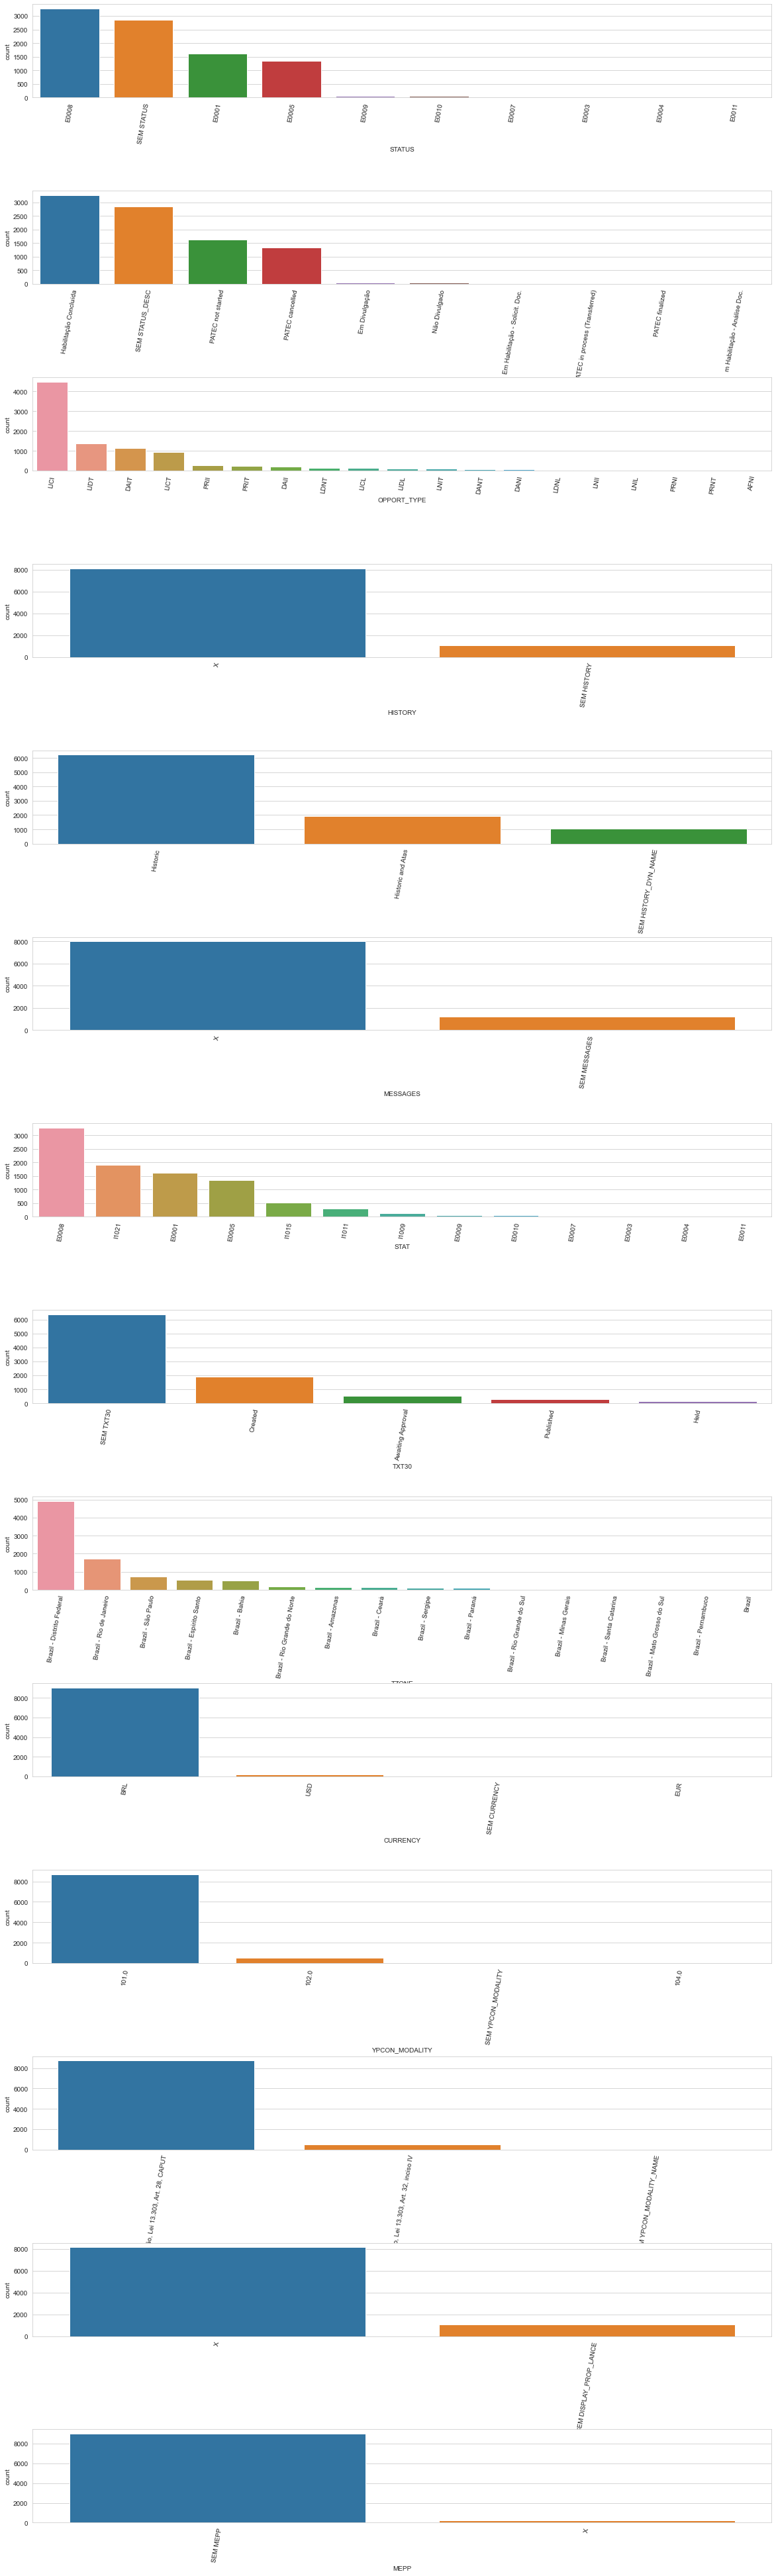

In [252]:
qtdplots = len(lista_objects)

if qtdplots==1:
  f, ax = plt.subplots(figsize=(30,20))
  sns.countplot(x=lista_objects[0], data=df, order=df[lista_objects[0]].value_counts().index)
else:

  print(qtdplots)
  f, ax = plt.subplots(qtdplots,1,figsize=(20,qtdplots*5))
  # Adjust the subplot layout parameters
  f.subplots_adjust(hspace=1, wspace=0.125)
  for idx,plts in enumerate(lista_objects):
    #print(plts)
    ax[idx]=sns.countplot(ax=ax[idx],x=plts, data=df, order=df[plts].value_counts().index)
    ax[idx].tick_params(axis='x', rotation=80)


##IMPLEMENTAR O LOOP PARA QUNADO ENCONTRA MAIS DE UM OBJECT

<AxesSubplot:xlabel='YPCON_QUOTE_REQUEST', ylabel='count'>

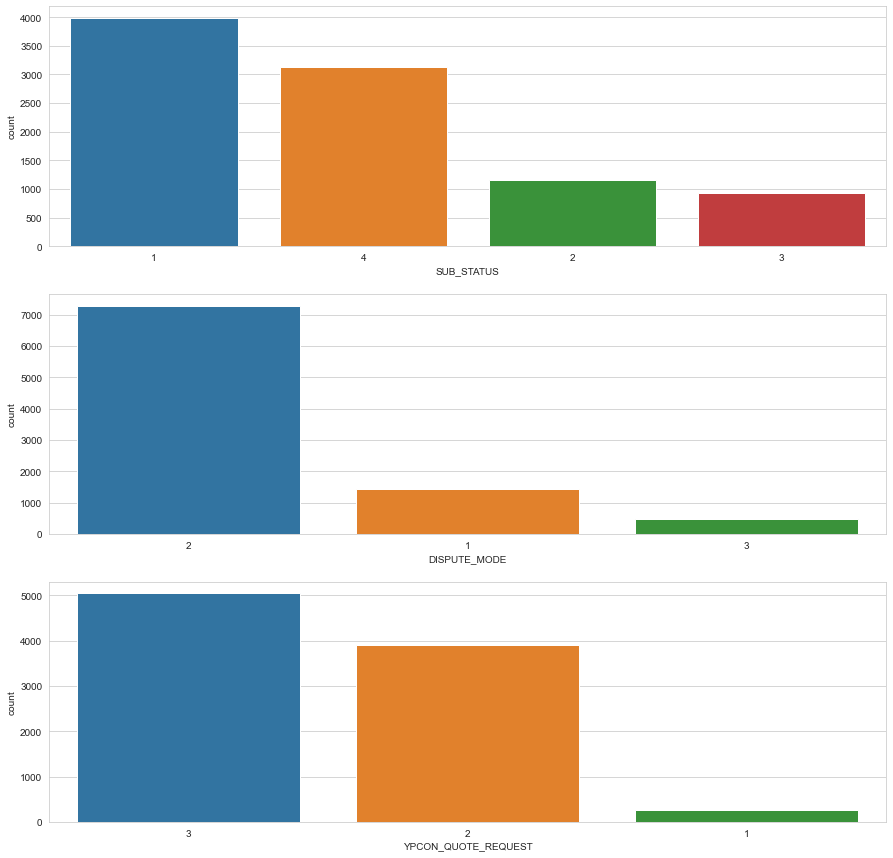

In [163]:
sns.set_style('whitegrid')
f, ax = plt.subplots(3,1,figsize=(15,15))
sns.countplot(ax=ax[0],x='SUB_STATUS', data=df, order=df['SUB_STATUS'].value_counts().index)
sns.countplot(ax=ax[1],x='DISPUTE_MODE', data=df, order=df['DISPUTE_MODE'].value_counts().index)
sns.countplot(ax=ax[2],x='YPCON_QUOTE_REQUEST', data=df, order=df['YPCON_QUOTE_REQUEST'].value_counts().index)

In [256]:
df['END_DATE_H_MES'] = df['END_DATE_H'].dt.to_period('M')

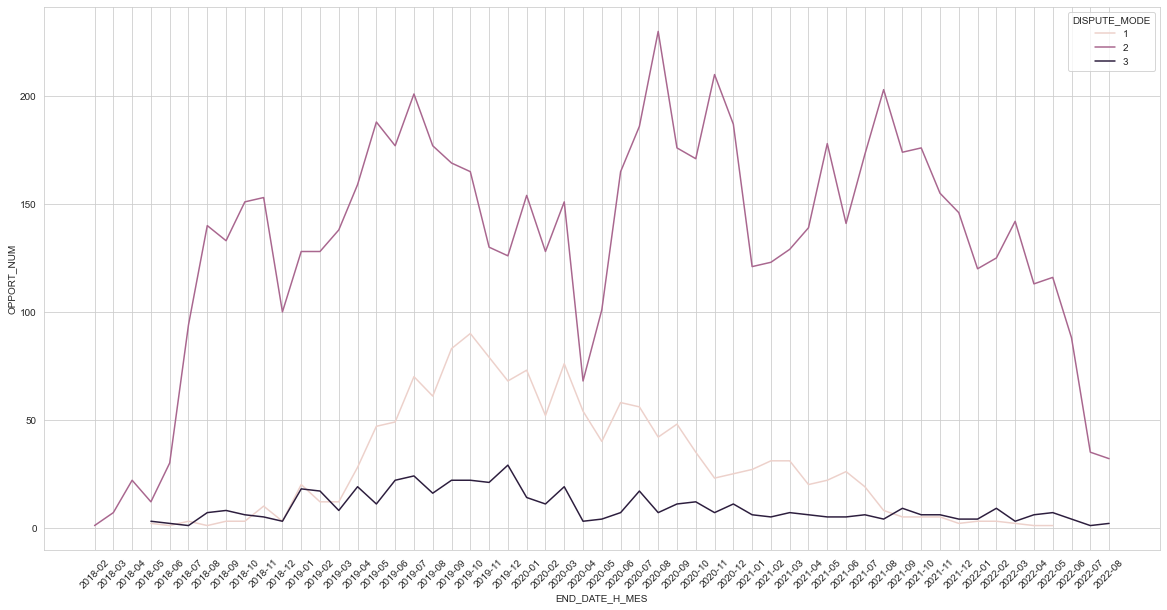

In [257]:
df_ano_mes_dispute = df.groupby(['END_DATE_H_MES','DISPUTE_MODE']).count()[['OPPORT_NUM']]
df_ano_mes_dispute.reset_index(inplace=True)
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_ano_mes_dispute, x=df_ano_mes_dispute['END_DATE_H_MES'].astype('str'), y=df_ano_mes_dispute['OPPORT_NUM'], ci=None, hue='DISPUTE_MODE')
ax.tick_params(axis='x', rotation=45)

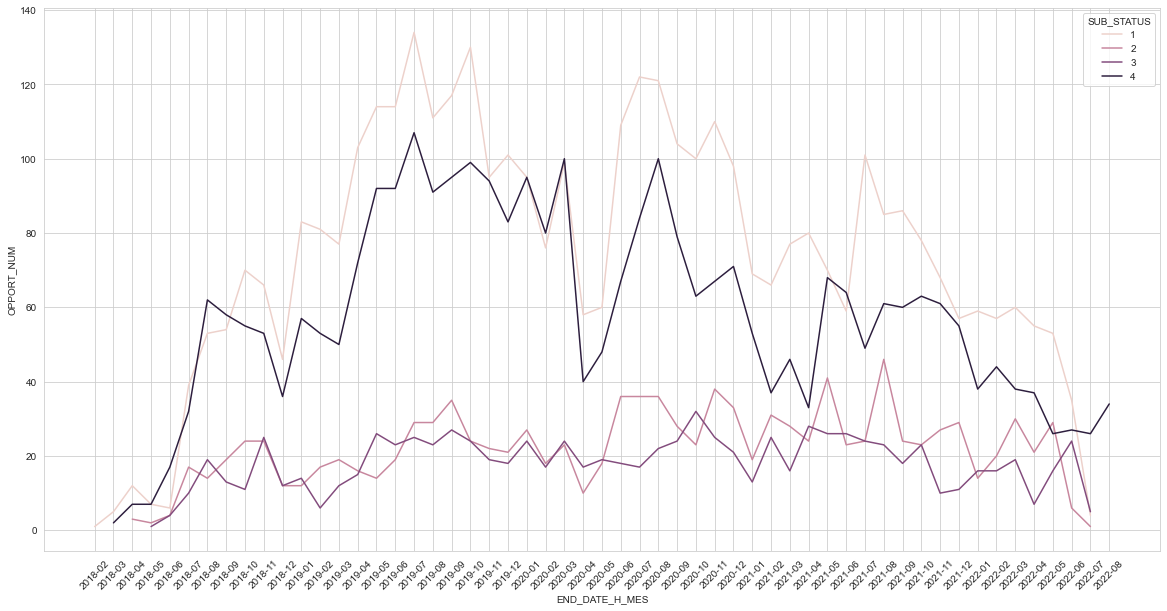

In [258]:
ano_mes_substatus = df.groupby(['END_DATE_H_MES','SUB_STATUS']).count()[['OPPORT_NUM']]
ano_mes_substatus.reset_index(inplace=True)
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=ano_mes_substatus, x=ano_mes_substatus['END_DATE_H_MES'].astype('str'), y=ano_mes_substatus['OPPORT_NUM'], ci=None, hue='SUB_STATUS')
ax.tick_params(axis='x', rotation=45)

In [259]:
df['DURACAO']= (df['END_DATE_H'].dt.date - df['START_DATE_H'].dt.date).dt.days
df['DURACAO'].describe().to_frame()
#df.shape
#df.to_excel('Api Principal_Tratado.xlsx')

,DURACAO
count,9213.000000
mean,27.974493
std,453.247309
min,1.000000
25%,10.000000
50%,19.000000
75%,28.000000
max,43467.000000


In [260]:
df = df[df['DURACAO']>0]
df = df[df['DURACAO']<200]
df.shape

(9188, 32)

In [ ]:
df['DURACAO'].describe()

c:\Users\kairo\anaconda3\envs\AmbienteKairo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


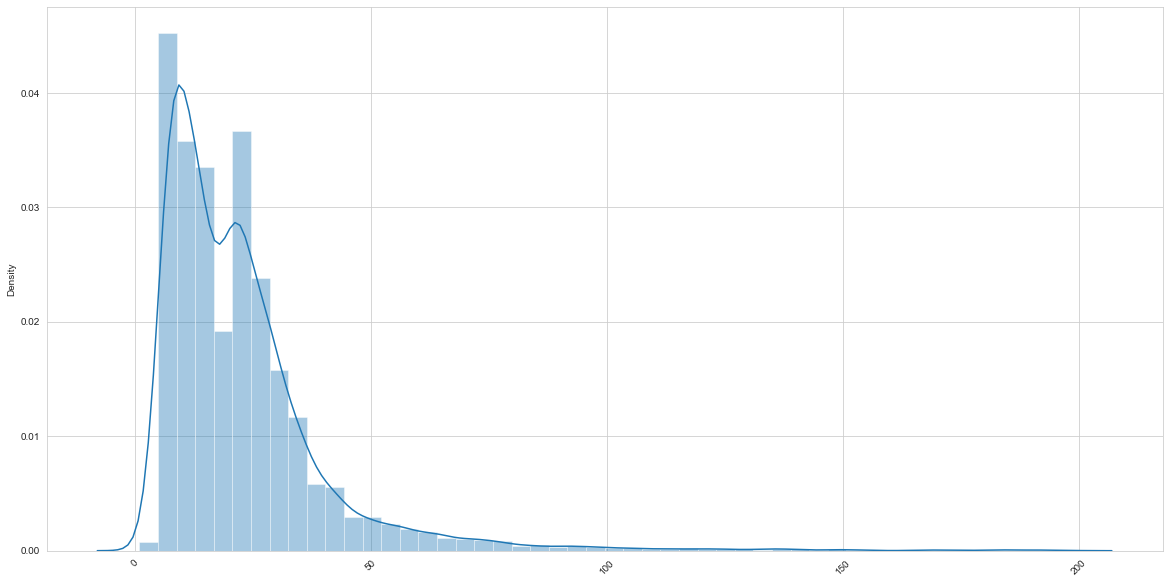

In [261]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(20,10))
sns.distplot(x=df['DURACAO'],bins=50)
ax.tick_params(axis='x', rotation=45)